In [166]:
!pip install tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 70.0 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 68.8 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 48.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Att

In [167]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [168]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
import imutils

# import data handling tools
import zipfile
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder 

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax,SGD , RMSprop ,AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils import to_categorical
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [169]:
paths =[]
categories =[]
filenames = os.listdir('/kaggle/input/brain-mri-images-for-brain-tumor-detection/no')
for file in filenames:
        category = file.split('.')[0]
        categories.append('0')
        paths.append(os.path.join('/kaggle/input/brain-mri-images-for-brain-tumor-detection/no',file))


In [170]:
paths2 =[]
categories2 =[]
filenames2 = os.listdir('/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes')
for file2 in filenames2:
        category2 = file2.split('.')[0]
        categories2.append('1')
        paths2.append(os.path.join('/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes',file2))
p = paths+paths2
c = categories+categories2
df = pd.DataFrame({
    'filename': p,
    'category': c
})            


In [171]:
df

,filename,category
0,/kaggle/input/brain-mri-images-for-brain-tumor...,0
1,/kaggle/input/brain-mri-images-for-brain-tumor...,0
2,/kaggle/input/brain-mri-images-for-brain-tumor...,0
3,/kaggle/input/brain-mri-images-for-brain-tumor...,0
4,/kaggle/input/brain-mri-images-for-brain-tumor...,0
...,...,...
248,/kaggle/input/brain-mri-images-for-brain-tumor...,1
249,/kaggle/input/brain-mri-images-for-brain-tumor...,1
250,/kaggle/input/brain-mri-images-for-brain-tumor...,1
251,/kaggle/input/brain-mri-images-for-brain-tumor...,1


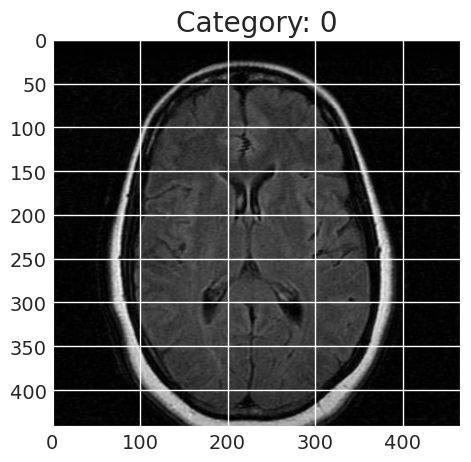

In [172]:
index = np.random.choice(df.index)
filename = df.loc[index, 'filename']
category = df.loc[index, 'category']
img = Image.open(filename)
plt.imshow(img)
plt.title(f'Category: {category}')
plt.show()

In [173]:
def crop_imgs(set_name):
    set_new = []
    for img in set_name:
        img = cv2.imread(img)
        img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
            )
        
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=1)
        thresh = cv2.dilate(thresh, None, iterations=1)
        # find contours in thresholded image, then grab the largest
        # one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

        # add extreme points
        img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
        img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
        img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
        img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

        # crop
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)
        
    return np.array(set_new)

In [174]:
df["image"] = crop_imgs(df["filename"])

In [175]:
df.head(1)

,filename,category,image
0,/kaggle/input/brain-mri-images-for-brain-tumor...,0,"[[[4, 4, 4], [4, 4, 4], [4, 4, 4], [4, 4, 4], ..."


In [176]:
def save_new_images(new_set, folder_name):
    j = 0
    for i, row in new_set.iterrows():
        # read image data from filename
        if row["category"] == '0':
            cv2.imwrite(folder_name+str(j)+'N'+'.jpg', row["image"])
        else:
            cv2.imwrite(folder_name+str(j)+'Y'+'.jpg', row["image"])
        j += 1



In [177]:
!mkdir dataframe

mkdir: cannot create directory ‘dataframe’: File exists


In [178]:
save_new_images(df, folder_name='dataframe/')

In [179]:
p =[]
c =[]
filenames3 = os.listdir('/kaggle/working/dataframe')
filenames3 = [f for f in filenames3 if f.endswith(".jpg")]
for file3 in filenames3:
    if file3.endswith(".jpg"):
        cat = file3.split('.')[0][-1]
        if cat == 'Y':
            c.append('1')
        else:
            c.append('0')
        p.append(os.path.join('/kaggle/working/dataframe',file3))

df2 = pd.DataFrame({
    'filename': p,
    'category': c
})            


In [180]:
df2

,filename,category
0,/kaggle/working/dataframe/79N.jpg,0
1,/kaggle/working/dataframe/232Y.jpg,1
2,/kaggle/working/dataframe/194Y.jpg,1
3,/kaggle/working/dataframe/12N.jpg,0
4,/kaggle/working/dataframe/216Y.jpg,1
...,...,...
248,/kaggle/working/dataframe/209Y.jpg,1
249,/kaggle/working/dataframe/71N.jpg,0
250,/kaggle/working/dataframe/237Y.jpg,1
251,/kaggle/working/dataframe/91N.jpg,0


In [181]:
strat = df2['category']
train_df,validate_df = train_test_split(df2,train_size = 0.80,shuffle = True, random_state = 42, stratify = strat)


In [182]:

batch_size = 8
img_size = (224,224)
channels = 3
img_shape = (img_size[0],img_size[1],channels)

# Create different ImageDataGenerator objects for training and testing/validation sets
tr_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.5, 1.2],
    horizontal_flip=True,
    vertical_flip=True)
ts_gen = ImageDataGenerator(rescale=1./255)

# Specify the directory argument for each set
train_gen = tr_gen.flow_from_dataframe(dataframe = train_df, x_col = 'filename' ,y_col = 'category', target_size = img_size, class_mode = 'binary',color_mode = 'rgb'
                                      , shuffle = True, batch_size = batch_size)
validate_gen = ts_gen.flow_from_dataframe(dataframe = validate_df,x_col = 'filename' ,y_col = 'category', target_size = img_size, class_mode = 'binary',color_mode = 'rgb',
                                          shuffle = True, batch_size = batch_size)

Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


In [183]:
total_image = np.concatenate([train_gen.labels,validate_gen.labels])
print('\n\n',{'No_brain_tumor_cases':len(np.where(total_image==0)[0]),
      'brain_tumor_cases':len(np.where(total_image==1)[0])})



 {'No_brain_tumor_cases': 98, 'brain_tumor_cases': 155}


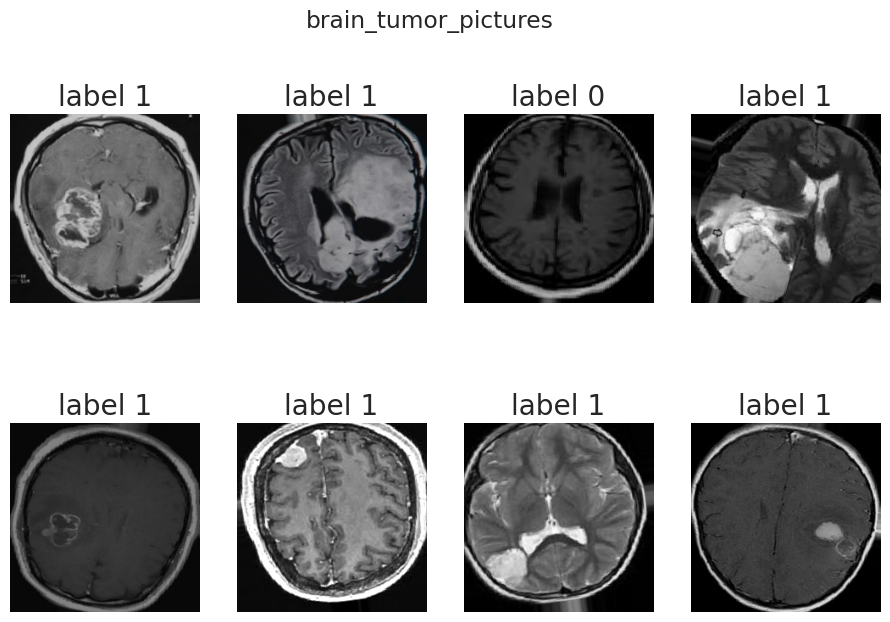

In [184]:
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
fig.suptitle("brain_tumor_pictures")
for k in range(8):
    images, labels = train_gen.next()
    i, j = k//4, k%4
 #   images = np.transpose(images, (0, 2, 3, 1))
    ax[i, j].imshow(images[0] , cmap = 'gray')
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')
plt.show()


In [193]:

base_model = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False,
    input_shape = img_shape,
    weights='imagenet',
     pooling= 'max'
)

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 42),
    Dense(1, activation= 'sigmoid')
])
model.compile(Adamax(learning_rate= 0.001), loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_16 (Bat  (None, 1536)             6144      
 chNormalization)                                                
                                                                 
 dense_32 (Dense)            (None, 256)               393472    
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_33 (Dense)            (None, 1)                 257       
                                                                 
Total params: 11,183,408
Trainable params: 11,093,033
Non-trainable params: 90,375
____________________________________

In [200]:
history = model.fit(x= train_gen, epochs = 30 , verbose = 1,validation_data = validate_gen,
                    validation_steps = None ,shuffle = True)

Epoch 1/30
26/26 [==============================] - 4s 164ms/step - loss: 0.9232 - accuracy: 0.9851 - val_loss: 1.4089 - val_accuracy: 0.6863
Epoch 2/30
26/26 [==============================] - 4s 159ms/step - loss: 0.9155 - accuracy: 0.9703 - val_loss: 1.1602 - val_accuracy: 0.8627
Epoch 3/30
26/26 [==============================] - 4s 159ms/step - loss: 0.9042 - accuracy: 0.9752 - val_loss: 1.4254 - val_accuracy: 0.7059
Epoch 4/30
26/26 [==============================] - 5s 185ms/step - loss: 0.9178 - accuracy: 0.9505 - val_loss: 1.0804 - val_accuracy: 0.8627
Epoch 5/30
26/26 [==============================] - 4s 160ms/step - loss: 0.8440 - accuracy: 0.9802 - val_loss: 1.0419 - val_accuracy: 0.9020
Epoch 6/30
26/26 [==============================] - 4s 159ms/step - loss: 0.8204 - accuracy: 0.9901 - val_loss: 1.1039 - val_accuracy: 0.8431
Epoch 7/30
26/26 [==============================] - 4s 157ms/step - loss: 0.7968 - accuracy: 0.9901 - val_loss: 2.1070 - val_accuracy: 0.3922
Epoch 

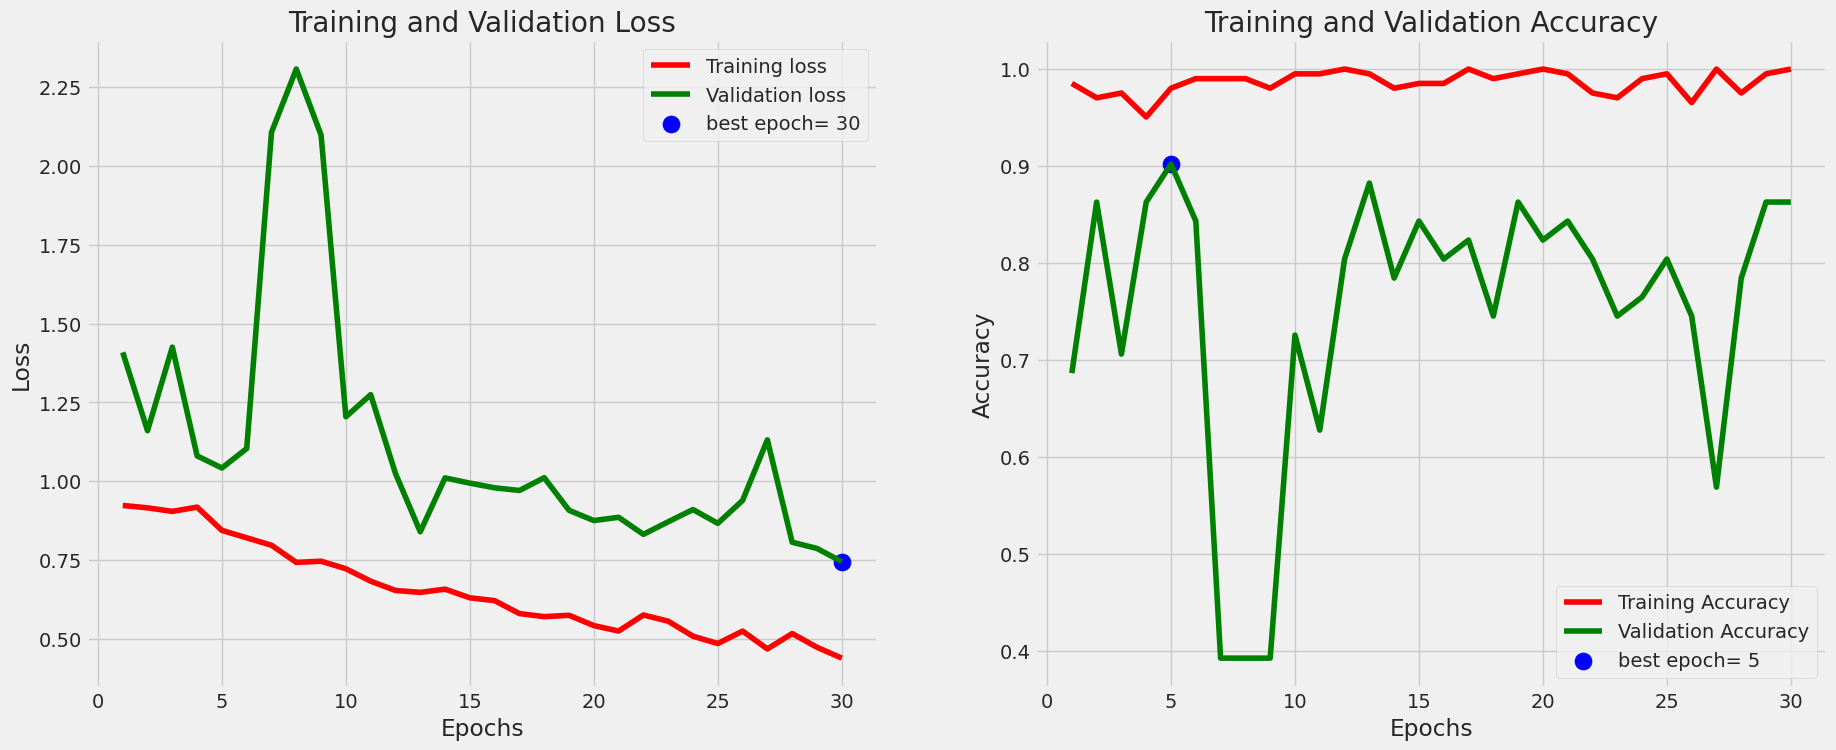

In [201]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [202]:
ts_length = len(validate_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(validate_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])

1/1 [==============================] - 0s 73ms/step - loss: 0.4969 - accuracy: 1.0000
Train Loss:  0.5587270259857178
Train Accuracy:  0.875
--------------------
Validation Loss:  0.4968874454498291
Validation Accuracy:  1.0


In [203]:
preds = model.predict_generator(validate_gen)
y_pred = np.where(preds>0.5,1,0)

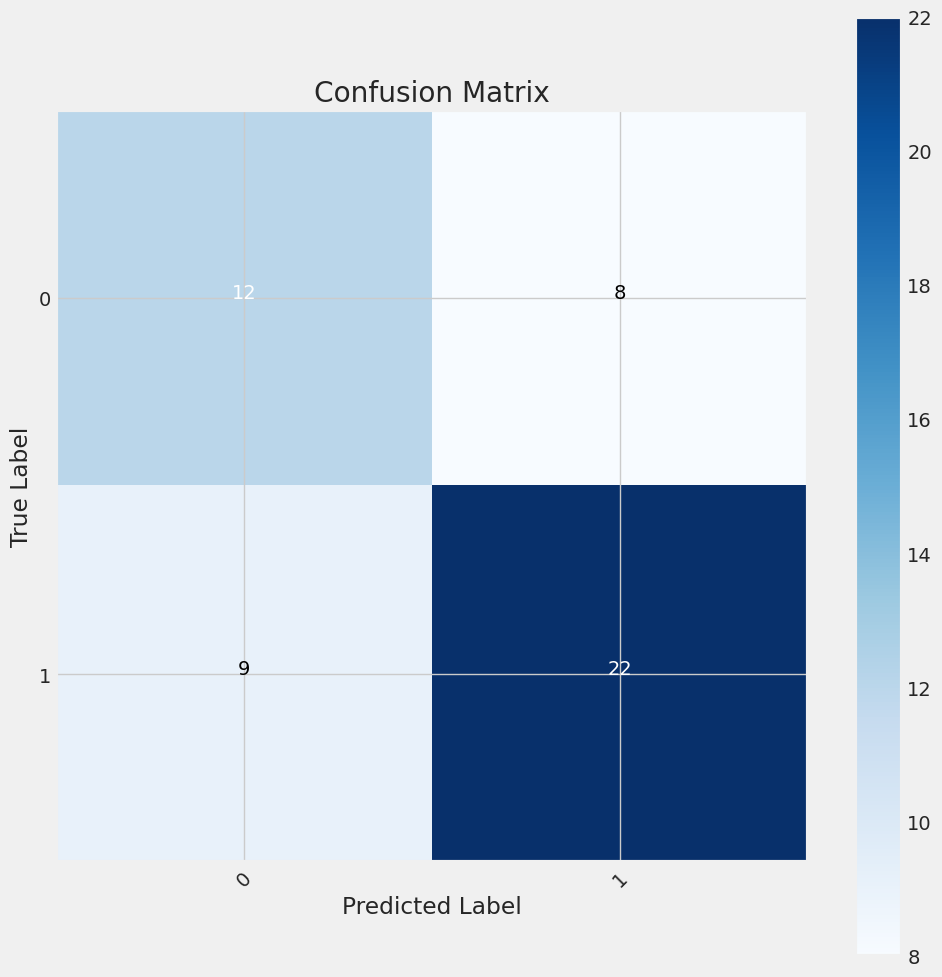

In [204]:
g_dict = validate_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(validate_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()